# MISO model - Training an end-to-end communications system on a Rayleigh-Fading channel based on an autoencoder model

This model is modified explicitly for the MISO scenario and using STBC encoding

Hint: To prevent memory garbage on disk suppress summary generation when not explicitly desired

[ Comment: The source code of Dr.-Ing. Jakob Hoydis' realisation of the autoencoder model from the paper 
"An Introduction to Deep Learning for the Physical Layer" (Timothy O’Shea; Jakob Hoydis, 02 October 2017) was used as a basis ] 

## Import Libraries

In [0]:
import numpy as np
import time
#%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import tensorflow as tf
import os
import pickle
import itertools as it
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Ignore if you do not have multiple GPUs


## This section defines the parameters which need to be fed to the model for the initializiation process

- Be aware that the parameters influence the size of the neural networks
- k is the number of information bits per channel usage, note that the number of possible messages is T = 2**(k*mt)
- n is the number of complex channel uses per message, is here fixed to n=1 !!
- seed can be used to reproduce identical results by fixing the seed of the random number generators, note that the line "tf.set_random_seed(self.seed)" should be commented out to set the seed in the graph, otherwise 'seed' is only used to distinguish between trained models in the saving process
- mt and mr are the number of transmit and recive antenna respectively, in MISO mr is fixed to one
    mt influences the dimension of the transmitted STBC, the dimension is fixed to mt x mt!
- model_file_1 and model_file_2 are only declared to distinguish models in saving processes

In [0]:
k = 2 # Number of information bits per channel usage
n = 1 # Number of complex channel uses per message
seed = 99 # Seed RNG reproduce identical results
mt = 3
mr = 1
model_file_1 = 'MISO/' 
model_file_2 = '_k_{}_n_{}_tx_{}_rx_{}_s_{}'.format(k, n, mt, mr, seed)

assert n is 1, "n does not equal 1"
assert mr is 1, "mr does not equal 1"

In [0]:
## Build Autoencoder with subfunctions 

In [0]:
class AE(object):
    def __init__(self, k, n, mt, mr, seed=None, filename=None):
        '''This function is the initialization function of the Autoencoder class'''
        self.k = k
        self.n = n
        self.mt = mt
        self.mr = mr
        self.bits_per_symbol = self.k / self.n
        self.M = 2 ** self.k
        self.T = 2 ** (self.mt * self.k)  # Anzahl möglicher Tupel
        self.seed = seed if (seed is not None) else int(time.time())
        self.graph = None
        self.sess = None
        self.vars = None
        self.saver = None
        self.constellations = None
        self.blers = None
        self.create_graph()
        self.create_session()
        self.sum = self.sum_writer()
        if filename is not None:
            self.load(filename)
        return

    def create_graph(self):
        '''This function creates the computation graph of the autoencoder'''
        self.graph = tf.Graph()
        with self.graph.as_default():
            
            # Comment out if you want to set the RNG seed
            #tf.set_random_seed(self.seed)
            
            # Placeholder which defines the input of the AE
            batch_size = tf.placeholder(tf.int32, shape=())

            # Create Channelmatrix
            hc, h_resh = self.channel_matrix()

            # Transmitter
            s = tf.random_uniform(shape=[batch_size], minval=0, maxval=self.T, dtype=tf.int64)
            x, x_plot, vars_enc = self.encoder(s, h_resh)

            # Channel
            noise_std = tf.placeholder(tf.float32, shape=())
            y = self.channel(x, hc, noise_std)

            # Receiver RTN
            yc_rtn, h_hat, _ = self.predecode(y, h_resh)
            s_hat, vars_dec = self.decoder(yc_rtn, h_resh)

            # Loss function
            cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=s, logits=s_hat)

            # Performance metrics
            preds = tf.nn.softmax(s_hat)
            s_hat_bit = tf.argmax(preds, axis=1)
            correct_predictions = tf.equal(s_hat_bit, s)
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            bler = 1 - accuracy

            # Optimizer
            lr = tf.placeholder(tf.float32, shape=())  # We can feed in any desired learning rate for each step
            train_op = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
            
            # Code lines which need to be implemented to monitor AE behavior through Tensorboard 
            with tf.name_scope('performance'):
                tf.summary.scalar('loss', cross_entropy)
                tf.summary.scalar('bler', bler)
            
            # Handle Training Parameters to monitor them (Tensorboard)
            train_vars = tf.trainable_variables()
            train_v = [vars_enc, vars_dec]
            
            merged = tf.summary.merge_all()

            # References to graph variables we need to access later
            self.vars = {
                'accuracy': accuracy,
                'batch_size': batch_size,
                'bler': bler,
                'cross_entropy': cross_entropy,
                'init': tf.global_variables_initializer(),
                'lr': lr,
                'noise_std': noise_std,
                'train_op': train_op,
                's': s,
                's_hat': s_hat,
                'x': x,
                'h': hc,
                'y': y,
                'x_plot': x_plot,
                'hc_plot': hc,
                's_hat_bit': s_hat_bit,
                'preds': preds,
                'merged': merged,
                'train_vars': train_vars,
                'train_v': train_v,
                'yc_rtn': yc_rtn,
                'h_hat': h_hat,
                'corr_preds': correct_predictions
            }
            self.saver = tf.train.Saver()
        return

    def create_session(self):
        '''Create a session for the autoencoder instance with the compuational graph'''
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.vars['init'])
        return

    def channel_matrix(self):
        '''The Channel Matrix Calculation (Rayleigh Fading Channel)'''
        
        # Define standard deviation as Rayleigh
        h_std_r = np.sqrt(0.5)
        h_mean_r = 0
        h_std_i = np.sqrt(0.5)
        h_mean_i = 0
        
        # Calculate channel symbols
        hr = tf.random_normal([self.mt, self.mr], mean=h_mean_r, stddev=h_std_r, dtype=tf.float32)
        hi = tf.random_normal([self.mt, self.mr], mean=h_mean_i, stddev=h_std_i, dtype=tf.float32)
        hc = tf.complex(hr, hi)
        
        # Channel in real notation
        h = tf.concat([tf.real(hc), tf.imag(hc)], axis=1)
        h_resh = tf.reshape(h, shape=[1, -1])

        return hc, h_resh

    def encoder(self, input, h):
        '''The transmitter'''
        
        # Embedding Layer  
        with tf.name_scope('enc_1'):
            # Embedding Matrix
            W = self.weight_variable((self.T, self.T))
            # Embedding Look-Up and ELU-Activation
            x = tf.nn.elu(tf.nn.embedding_lookup(W, input), name='enc_1')
            # Store layer parameters to monitor them in Tensorboard
            var_enc_1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'enc_1')
        
        # Hidden Layer
        with tf.name_scope('enc_2'):
            # Dense Layer
            x = tf.layers.dense(x, self.mt * self.M, activation=tf.nn.leaky_relu, name='enc_2')
            # Store layer parameters to monitor them in Tensorboard
            var_enc_2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'enc_2')
        
        # Hidden Layer    
        with tf.name_scope('enc_3'):
            # Dense Layer
            x = tf.layers.dense(x, 2 * self.mt * self.mt, activation=tf.nn.leaky_relu, name='enc_3')
            # Store layer parameters to monitor them in Tensorboard
            var_enc_3 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'enc_3')
            
        # Output Layer
        with tf.name_scope('enc_4'):
            # Dense Layer
            x = tf.layers.dense(x, 2 * self.mt * self.mt, activation=None, name='enc_4')
            # Store layer parameters to monitor them in Tensorboard
            var_enc_4 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'enc_4')
        
        # Concat all summaries of the layer parameters
        vars = [var_enc_1, var_enc_2, var_enc_3, var_enc_4]
        
        # Real to complex transformation
        x = tf.reshape(x, shape=[-1, 2])
        x = tf.reshape(tf.complex(x[::, 0], x[::, 1]), shape=[-1, 1])
        
        # Power Normalization (Comment out the one you want to use)
        
        # Average power normalization over all
        norma = tf.sqrt(tf.reduce_mean(tf.square(tf.abs(x)), axis=0))
        x = x / tf.cast(norma, dtype=tf.complex64)
        '''
        # Power Normalization = 1
        norma = tf.reciprocal(tf.sqrt(tf.square(tf.abs(x))))
        x = tf.multiply(x, tf.cast(norma, dtype=tf.complex64))
        '''
        
        # STCB-Mapping or shaping
        x = tf.reshape(x, shape=[-1, self.mt])
        
        '''
        # Average power normalization over each antenna
        norma = tf.sqrt(tf.reduce_mean(tf.square(tf.abs(x)), axis=0))
        x = x / tf.cast(norma, dtype=tf.complex64)
        '''
                    
        # x_plot needs to be reshaped sometimes for plotting purposes
        x_plot = x
                
        return x, x_plot, vars


    def channel(self, input, hc, noise_std):
        '''The channel'''      
        
        # Channel Matrix Multiplicatipon
        yc = tf.matmul(input, hc)
        
        # Noise
        nr = tf.random_normal(tf.shape(yc), mean=0.0, stddev=(noise_std/np.sqrt(2)), dtype=tf.float32)
        ni = tf.random_normal(tf.shape(yc), mean=0.0, stddev=(noise_std/np.sqrt(2)), dtype=tf.float32)
        nc = tf.complex(nr, ni)
        yc = tf.add(yc, nc)
        
        return yc
          
    def predecode(self, yc, h):
        '''Predecoder-NN with Zero-Forcing Orientation (Input: Received Symbols plus CSI)'''
        
        # Complex to real Transformation
        yc = tf.reshape(yc, shape=[-1, 1])
        y = tf.concat([tf.real(yc), tf.imag(yc)], axis=1)     
        y = tf.reshape(y, shape=[-1, 2*self.mt])

        # Concat CSIR to y
        h = tf.tile(h, [tf.shape(y)[0], 1])
        input = tf.concat([y, h], 1)
        
        # Input Layer
        with tf.name_scope('pre_1'):
            # Dense Layer
            h_hat = tf.layers.dense(input, 12, activation=tf.tanh, name='pre_1')
            # Store layer parameters to monitor them in Tensorboard
            var_pre_2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'pre_1')
            
        # Output Layer
        with tf.name_scope('pre_2'):
            # Dense Layer
            h_hat = tf.layers.dense(h_hat, 2 * self.mt, activation=None, name='pre_2')
            # Store layer parameters to monitor them in Tensorboard
            var_pre_3 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'pre_2')
        
        # Concat all summaries of the layer parameters
        vars = [var_pre_1, var_pre_2] 
        
        # Real to Complex and reshape to right Dimensions
        h_hat = tf.reshape(h_hat, shape=[-1, 2])
        h_hat = tf.complex(h_hat[:, 0], h_hat[:, 1])
        h_hat = tf.reshape(h_hat, shape=[-1, self.mt])
        h_hat = tf.reduce_mean(h_hat, axis=0)
        h_hat = tf.reshape(h_hat, shape=[1, -1])
        
        # Multiplication of learned Matrix with received Symbols
        yc = tf.reshape(yc, shape=[-1, self.mr])
        yc_rtn = tf.matmul(yc, h_hat)        
        
        return yc_rtn, h_hat, vars
    
    def decoder(self, yc, h):
        '''The Receiver (Decoder-NN)'''
        
        # Complex to real plus reshape to Dimension as in Output Vector of Encoder-NN
        yc = tf.reshape(yc, shape=[-1, 1])
        y = tf.concat([tf.real(yc), tf.imag(yc)], axis=1)     
        y = tf.reshape(y, shape=[-1, 2*self.mt*self.mt])

        input = y
        
        # Input Layer
        with tf.name_scope('dec_1'):
            # Dense Layer
            y = tf.layers.dense(input, self.mt*self.T, activation=tf.nn.leaky_relu, name='dec_1')
            # Store layer parameters to monitor them in Tensorboard
            var_dec_1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'dec_1')
        
        # Hidden Layer
        with tf.name_scope('dec_2'):
            # Dense Layer
            y = tf.layers.dense(y, self.mt*self.T, activation=tf.nn.leaky_relu, name='dec_2')
            # Store layer parameters to monitor them in Tensorboard
            var_dec_2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'dec_2')
        
        # Hidden Layer
        with tf.name_scope('dec_3'):
            # Dense Layer
            y = tf.layers.dense(y, self.mt*self.T, activation=tf.nn.leaky_relu, name='dec_3')
            # Store layer parameters to monitor them in Tensorboard
            var_dec_3 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'dec_3')
        
        # Output Layer
        with tf.name_scope('dec_4'):
            # Dense Layer
            y = tf.layers.dense(y, self.T, activation=None, name='dec_4')
            # Store layer parameters to monitor them in Tensorboard
            var_dec_4 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'dec_4')
        
        # Concat all summaries of the layer parameters 
        vars = [var_dec_1, var_dec_2, var_dec_3, var_dec_4]
       
        return y, vars

    def EbNo2Sigma(self, ebnodb):
        '''Convert Eb/No in dB to noise standard deviation'''
        ebno = 10 ** (ebnodb / 10)
        return np.sqrt(1 / ((1 / self.mt) * self.bits_per_symbol * ebno))

    def gen_feed_dict(self, batch_size, ebnodb, lr):
        '''Generate a feed dictionary for training and validation'''
        return {
            self.vars['batch_size']: batch_size,
            self.vars['noise_std']: self.EbNo2Sigma(ebnodb),
            self.vars['lr']: lr,
        }

    def test_step(self, batch_size, ebnodb):
        '''Compute the BLER over a single batch and Eb/No'''
        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
        return bler
 
    def train(self, training_params, validation_params):
        '''Main training function, which handles train and validation paramters'''
        
        # Training and validation loop
        for index, params in enumerate(training_params):
            batch_size, lr, ebnodb, iterations, repeats = params
            print('\nBatch Size: ' + str(batch_size) +
                  ', Learning Rate: ' + str(lr) +
                  ', EbNodB: ' + str(ebnodb) +
                  ', Iterations: ' + str(iterations) +
                  ', Repeats: ' + str(repeats))

            val_size, val_ebnodb, val_steps = validation_params[index]
            
            for j in range(repeats):          
                for i in range(iterations):
                    
                    # Call training function
                    self.train_step(batch_size, ebnodb, lr)
                    
                    # Observe val results
                    if i%val_steps==0 and index==0 and j==0:
                        bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
                        print(bler)
           
            bler = self.sess.run(self.vars['bler'], feed_dict=self.gen_feed_dict(val_size, val_ebnodb, lr))
            print(bler)
            
        return

    def train_step(self, batch_size, ebnodb, lr):
        '''A single training step: Computes one iteration of the graph and  optimizes neural net paramters'''
        summary, _ = self.sess.run([self.vars['merged'], self.vars['train_op']], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr))
        return summary
    
    def plot_constellation(self, maxrange=None):
        '''Generate a plot of the current constellation for all antennas in one constellation diagramm'''
        
        # Get symbols 
        x = self.transmit(range(self.T))
        x = np.reshape(x, (self.T, self.mt*self.mt))
        
        # Define plot parameters
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        colours = cm.cmap_d['gist_rainbow'](np.linspace(0, 1, self.T))
        image = plt.figure(figsize=(6, 6))
        plt.grid(True)
        plt.xlim(-maxrange, maxrange)
        plt.ylim(-maxrange, maxrange)
        
        # Calculate bit-block assignement
        bit_assigned = self.assign_bits_to_msg(100, 30, 10000)
        
        # Plot symbols
        for j in range(self.T):
            for k in range(self.mt*self.mt):
                if k == 0:
                    plt.scatter(x[j, k].real, x[j, k].imag, marker='x', label=bit_assigned[j], c=colours[j], s=75)
                else:
                    plt.scatter(x[j, k].real, x[j, k].imag, marker='x', c=colours[j])
                plt.annotate(k, (x[j, k].real+0.05, x[j, k].imag+0.05))
        
        plt.legend(bit_assigned, loc='upper center', bbox_to_anchor=(1.2,1), ncol=1, fontsize=16, handletextpad=0.05, labelspacing=0.2)
        parameter = {"ytick.color": "k", "xtick.color": "k", "axes.labelcolor": "k", "axes.edgecolor": "k"}
        plt.xlabel('I', fontsize=18)
        plt.ylabel('Q', fontsize=18)
        plt.tick_params(labelsize=16)
        plt.rcParams.update(parameter)
        image.axes[0].set_xticks(np.array([-2, -1, 0, 1, 2]))                                          
        image.axes[0].set_yticks(np.array([-2, -1, 0, 1, 2]))
        return x, image
    
    def plot_const_antwise(self, maxrange=None):
        '''Generate a plot of the current constellation with subplots over each different antenna and timeslot in STBC'''
        
        # Get symbols 
        x = self.transmit(range(self.T))
        
        
        # Define plot parameters
        if (maxrange is None):
            maxrange = np.max(np.abs(x))
        colours = cm.cmap_d['gist_rainbow'](np.linspace(0, 1, self.T))    
        image = plt.figure(figsize=(12, 12))
        num_of_subplts = self.mt*self.mt
        
        # Rehsape x to work with it easier
        x = np.reshape(x, (self.T, self.mt*self.mt))
        x = np.transpose(x)
        
        # Calculate bit-block assignement
        bit_assigned = self.assign_bits_to_msg(100, 30, 10000)
        
        # Plot symbols antenna wise
        a, t = 1, 1
        for k in range(num_of_subplts):
            ax = image.add_subplot(self.mt, self.mt, k+1)
            for j in range(self.T):
                ax.scatter(x[k, j].real, x[k, j].imag, marker='x', label=bit_assigned[j], c=colours[j], s=75)
            ax.grid(True)
            ax.set_xlim(-maxrange, maxrange)
            ax.set_ylim(-maxrange, maxrange)
                
            title = 'Antenne {} , T = {}'.format(a, t)
            ax.set_title(title, fontsize=18)
            ax.set_xlabel('I', fontsize=18)
            ax.set_ylabel('Q', fontsize=18)
            ax.locator_params(nbins=5)
            ax.tick_params(labelsize=16)
            if ((k+1) % self.mt) == 0:
                a = 1
                t += 1
            else:
                a += 1
            image.axes[k].set_xticks(np.array([-2, -1, 0, 1, 2]))                                          
            image.axes[k].set_yticks(np.array([-2, -1, 0, 1, 2]))
        
        image.tight_layout() 
        plt.legend(bit_assigned, loc='upper center', bbox_to_anchor=(1.28,1.6), ncol=1, fontsize=16, handletextpad=0.05, labelspacing=0.2)  
        parameter = {"ytick.color": "k", "xtick.color": "k", "axes.labelcolor": "k", "axes.edgecolor": "k"}
        plt.rcParams.update(parameter)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)      
        
        return x, image
    
    def plot_receive(self, ebn0, channel_realizations, rtn=0, maxrange=None):
        '''Generate a plot of the received constellation (Be Aware: with rtn = 0 or 1 you influence 
                    whether you want to plot the symbols before or after the Predecoder-NN'''
        
        # Get Symbols
        if rtn == 1:
            y = self.receive_RTN(ebn0, channel_realizations)
        else:
            y = self.receive(ebn0, channel_realizations)
            
        # Define plot parameters   
        if (maxrange is None):
            maxrange = np.max(np.abs(y))
        colours = cm.cmap_d['gist_rainbow'](np.linspace(0, 1, self.T)) 
        
        # Calculate bit assignment
        bit_assigned = self.assign_bits_to_msg(100, 30, 10000)
        
        # Plot symbols before Predecoding
        if rtn == 0:
            image = plt.figure(figsize=(12, (12/self.mt)))
            num_of_subplts = self.mt
            y = np.reshape(y, (-1, num_of_subplts))
            a, t = 1, 1
            y = np.transpose(y)
            for k in range(num_of_subplts):
                ax = image.add_subplot(1, self.mt, k+1)
                symbols = y[k]
                symbols = np.reshape(symbols, (-1, self.T))
                for j in range(self.T):
                    ax.scatter(symbols[:, j].real, symbols[:, j].imag, marker='x', label=bit_assigned[j], c=colours[j], s=75)
                ax.grid(True)
                ax.set_xlim(-maxrange, maxrange)
                ax.set_ylim(-maxrange, maxrange)
                    
                title = 'Antenne {} , T = {}'.format(a, t)
                ax.set_title(title, fontsize=18)
                ax.set_xlabel('I', fontsize=18)
                ax.set_ylabel('Q', fontsize=18)
                
                ax.tick_params(labelsize=16)
                ax.locator_params(nbins=5)
                t += 1
                #image.axes[k].set_xticks(np.array([-2, -1, 0, 1, 2]))                                          
                #image.axes[k].set_yticks(np.array([-2, -1, 0, 1, 2]))
            image.tight_layout()
            plt.locator_params(nbins=5)
            image.legend(bit_assigned, loc='lower center', bbox_to_anchor=(0.5,-0.5), ncol=5, fontsize=16, handletextpad=0.05, labelspacing=0.2)
        
        # Plot symbols after Predecoding
        if rtn == 1:

            image = plt.figure(figsize=(12, 12))
            num_of_subplts = self.mt*self.mt
            y = np.reshape(y,(-1, num_of_subplts))
            a, t = 1, 1
            y = np.transpose(y)
            for k in range(num_of_subplts):
                ax = image.add_subplot(self.mt, self.mt, k+1)
                symbols = y[k]
                symbols = np.reshape(symbols, (-1, self.T))
                for j in range(self.T):
                    ax.scatter(symbols[:, j].real, symbols[:, j].imag, marker='x', label=bit_assigned[j], c=colours[j], s=75)
                ax.grid(True)
                ax.set_xlim(-maxrange, maxrange)
                ax.set_ylim(-maxrange, maxrange)
                    
                title = 'Antenne {} , T = {}'.format(a, t)
                ax.set_title(title, fontsize=18)
                ax.set_xlabel('I', fontsize=18)
                ax.set_ylabel('Q', fontsize=18)
                ax.locator_params(nbins=5)
                #ax.yaxis.labelpad = -10
                ax.tick_params(labelsize=16)
                if ((k+1) % self.mt) == 0:
                    a = 1
                    t += 1
                else:
                    a += 1
                    
            image.legend(bit_assigned, loc='upper center', bbox_to_anchor=(1.1, 0.8), ncol=1, fontsize=16, handletextpad=0.05, labelspacing=0.2)
            image.tight_layout()        
            plt.locator_params(nbins=5)
        
        parameter = {"ytick.color": "k", "xtick.color": "k", "axes.labelcolor": "k", "axes.edgecolor": "k"}
        plt.rcParams.update(parameter)
        return y
    
    def transmit(self, s):
        '''Returns the transmitted signals corresponding to message indices (BE AWARE: RETURNS x_plot and not x!)'''
        return self.sess.run(self.vars['x_plot'], feed_dict={self.vars['s']: s})
    
    def receive(self, ebnodb, channel_realizations):
        '''Returns the received signals of multiple sending of the T consecutive messages
                            Returns: Array of T x channel_realizations'''
        y_ch = []
        s = range(self.T)
        noise_std = self.EbNo2Sigma(ebnodb)
        for i in range(channel_realizations):
            y = self.sess.run(self.vars['y'], feed_dict={self.vars['s']: s, self.vars['noise_std']: noise_std})
            y_ch.append(y)        
        
        return y_ch
    
    def receive_RTN(self, ebnodb, channel_realizations):
        '''Returns the symbols after the RTN by multiple sending of the T consecutive messages 
                            Returns: Array of T x channel_realizations'''
        y_ch = []
        s = range(self.T)
        noise_std = self.EbNo2Sigma(ebnodb)
        for i in range(channel_realizations):
            y = self.sess.run(self.vars['yc_rtn'], feed_dict={self.vars['s']: s, self.vars['noise_std']: noise_std})
            y_ch.append(y)        
        
        return y_ch 

    def sum_writer(self):
        '''Summary writer function which is needed for Tensorboard visualization'''
        sum_writer = tf.summary.FileWriter(model_file_1 + 'Summary', self.sess.graph)
        return sum_writer

    def get_graphkeys(self):
        '''Get the trained weights and biases of the layers'''
        theta = self.sess.run(self.vars['train_v'])
        return theta

    def weight_variable(self, shape):
        '''Xavier-initialized weights in Embedding Matrix'''
        (fan_in, fan_out) = shape
        low = np.sqrt(6.0 / (fan_in + fan_out))
        high = -np.sqrt(6.0 / (fan_in + fan_out))
        return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))
    
    def save(self, filename):
        '''Save the current model'''
        return self.saver.save(self.sess, filename)
    
    def load(self, filename):
        '''Load a pretrained model'''
        return self.saver.restore(self.sess, filename)
    
    def bler_sim(self, ebnodbs, batch_size, iterations):
        '''Monte Carlo simulations of BLER for a range of Eb/No. average over multiple batches with small size '''       
        BLER = np.zeros_like(ebnodbs)
        for i in range(iterations):
            bler = np.array([self.sess.run(self.vars['bler'],
                            feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0)) for ebnodb in ebnodbs])
            BLER = BLER + bler/iterations
        return BLER
    
    def plot_bler(self, EbNodB, BLER):
        '''Plot a BLER curve'''
        image = plt.figure(figsize=(10,8))
        plt.plot(EbNodB, BLER, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('Block-error rate', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5, 1])
        parameter = {"ytick.color": "k", "xtick.color": "k", "axes.labelcolor": "k", "axes.edgecolor": "k"}
        plt.rcParams.update(parameter)
        plt.legend(['Autoencoder'], prop={'size': 16}, loc='upper right')
        return image

    def assign_bits_to_msg(self, batch_size, ebnodb, channel_realisations):
        '''Compute bit assignment to message indices: Get average BER over batchsize on multiple channelrealizations 
                for specific EbN0; Take the bit assignment which produces lowest BER'''
        
        prob_arr = []
        # Average the prediction probabilities for each message when decoded over a loop
        for i in range(channel_realisations):            
            prob = np.zeros((self.T, self.T))
            s, preds = self.sess.run([self.vars['s'], self.vars['preds']], feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
            
            for ind, msg in enumerate(s):
                prob[msg] = prob[msg] + preds[ind]
                
            unique, counts = np.unique(s, return_counts=True)
            occurence = dict(zip(unique, counts))           
        
            for msg, cnts in occurence.items():
                if (cnts == 0):
                    prob[msg] = prob[msg]
                else:
                    prob[msg] = prob[msg] / cnts
                    
            prob_arr.append(prob)
            
        prob = np.mean(prob_arr, axis=0)
        
        # Try out all bit assignments possible for the bitblocks and compute BER
        bit_one = []
        bit_list = []
        msg_list = list(map(list, it.product([0, 1], repeat=(self.k*self.mt))))
        
        for k in range(len(msg_list)):
            msg_list = np.roll(msg_list, k)
            bit_list.append(msg_list)
            bit_err = []
            # Compute Hamming Distance of the bitblock assignment (== # of bit errors if wrongly predicted)
            for i in range(len(msg_list)):
                for j in range(len(msg_list)):
                    hamming_dist = np.sum(np.bitwise_xor(msg_list[i], msg_list[j]))
                    bit_err.append(hamming_dist)
                    
            # Calculate BER with hamming dist matrix and prediction probabilities             
            bit_err = np.reshape(np.asarray(bit_err), (self.T, self.T))
            bit_prob = np.multiply(prob, bit_err) / (self.T*self.k*self.mt)
            bit_one.append(np.mean(bit_prob))
        
        # Check for the assigmnent with lowest BER
        index_min_BER = np.argmin(bit_one)
        assigned_bits = bit_list[int(index_min_BER)]
               
        return assigned_bits
    
    def calc_BER(self, batch_size, ebnodb, channel_realisations, assigned_bits):
        '''Calculate average BER over a ebno-level with batchsize messages per iterations 
                            and over # of channel realizations (Monte-Carlo Simulation)'''
        
        bit_err = []
        prob_arr = []
        errorsum = 0
        
        # Average the prediction probabilities for each message when decoded over a loop
        for i in range(channel_realisations):            
            prob = np.zeros((self.T, self.T))
            
            # Run graph and get predictions
            s, preds, corr_preds = self.sess.run([self.vars['s'], self.vars['preds'], self.vars['corr_preds']], 
                                     feed_dict=self.gen_feed_dict(batch_size, ebnodb, lr=0))
            
            for ind, msg in enumerate(s):
                prob[msg] = prob[msg] + preds[ind]
                
            unique, counts = np.unique(s, return_counts=True)
            occurence = dict(zip(unique, counts))           
        
            for msg, cnts in occurence.items():
                if (cnts == 0):
                    prob[msg] = prob[msg]
                else:
                    prob[msg] = prob[msg] / cnts
                    
            prob_arr.append(prob)
            
            # Count absolute message errors
            block_errors_batch = batch_size - np.sum(corr_preds)
            errorsum += block_errors_batch
            
        prob = np.mean(prob_arr, axis=0)
        
        # Compute Hamming Distance of the bitblock assignment (== # of bit errors if wrongly predicted)
        for i in range(len(assigned_bits)):
                for j in range(len(assigned_bits)):
                    hamming_dist = np.sum(np.bitwise_xor(assigned_bits[i], assigned_bits[j]))
                    bit_err.append(hamming_dist)
        
        # Convert the probability distribution of the predictions to BER with the already assigned bits
        bit_err = np.reshape(np.asarray(bit_err), (self.T, self.T))
        bit_prob = np.multiply(prob, bit_err) / (self.T*self.k*self.mt) 
        BER = np.sum(bit_prob)

        return BER, errorsum
    
    def plot_BER(self, batch_size, ebnodbs, channel_realisations, logdir):
        '''Plot BER over various ebno-levels'''
        
        ti = time.time()
        ber = []
        # Initialize Logfile
        logmsg = 'Simulation starting time: ' + str(ti) + '\n \n'
        with open(logdir, 'w+') as logfile:
                        logfile.write(logmsg)
        
        # Assign bit-blocks to messages    
        assigned_bits = self.assign_bits_to_msg(1000, 30, 10000)
        
        # Iterate over ebno-levels and compute BER with minimum computation and termination citeria
        for _, ebno in enumerate(ebnodbs):
            i = 1
            blockerror_sum = 0
            ber_i = []
            while True:
                ber_val, abs_blockerrors = ae.calc_BER(batch_size, ebno, channel_realisations, assigned_bits)
                blockerror_sum += abs_blockerrors
                
                # Minimum block errors
                if (0 <= ebno < 15) and i < 50 and blockerror_sum < 100:
                    ber_i.append(ber_val)
                    i += 1
                    
                elif (15 <= ebno < 20) and i < 50 and blockerror_sum < 100:
                    ber_i.append(ber_val)
                    i += 1
                                        
                elif (20 <= ebno < 27) and i < 50 and blockerror_sum < 1000:
                    ber_i.append(ber_val)
                    i += 1
                                        
                elif (27 <= ebno <= 35) and i < 50 and blockerror_sum < 1000:
                    ber_i.append(ber_val)
                    i += 1
                
                # Min iterations to average
                elif (15 <= ebno < 20) and (i < 5):
                    ber_i.append(ber_val)
                    i += 1
                
                elif (20 <= ebno < 28) and (i < 10):
                    ber_i.append(ber_val)
                    i += 1
                    
                elif (28 <= ebno <= 35) and (i < 15):
                    ber_i.append(ber_val)
                    i += 1
                    
                else:
                    ber_i.append(ber_val)
                    break
                    
            tim = time.time() - ti
            ber_app = np.mean(ber_i, dtype=np.float64) #np.sum(ber_i) / len(ber_i)     
            msg = 'EbN0: ' + str(ebno) + ' , Zeit: ' + str(round(tim/60, 2)) + 'min , Averaged over: ' + str(len(ber_i)) + \
                  ', Absolute Blockerrors: ' + str(blockerror_sum) + ', BER: ' + str(np.asscalar(np.round(ber_app, 5))) + '\n'
            print(msg)
            with open(logdir, 'a+') as logfile:
                logfile.write(msg)
            ber.append(ber_app)
        
        # Plot BER-Curve
        image = plt.figure(figsize=(10,8))
        plt.plot(ebnodbs, ber, '-r', linewidth=2.0)
        plt.yscale('log')
        plt.xlabel('EbNo (dB)', fontsize=18)
        plt.ylabel('avBER', fontsize=18)
        plt.grid(True)
        plt.ylim([1e-5, 1])
        parameter = {"ytick.color": "k", "xtick.color": "k", "axes.labelcolor": "k", "axes.edgecolor": "k"}
        plt.rcParams.update(parameter)
        plt.legend(['Autoencoder'], prop={'size': 16}, loc='upper right')
        
        return image, ber


## Trainingsloop 1 as described in Master's Thesis

In [0]:
# First define Training parameters such as Train-Ebno, Learning Rate, batchsize, validation parameters, repeats
train_EbNodB_arr = [3, 7, 11, 13, 17, 22, 25, 28, 32]  
lr = np.round(np.linspace(0.01, 0.0001, num=len(train_EbNodB_arr)), 5)
batch_size_tr = 1000
iterations = 10000
repeat = 1  # With that number you force to train on one EbN0 Level multiple times
repeats = np.rint(np.linspace(repeat, repeat, num=len(train_EbNodB_arr))).astype(np.int32)
val_EbNodB_arr = train_EbNodB_arr

# Initialize Model
print('Initializing Graph... with M = ' + str(2**k))
ae = AE(k, n, seed)
print('Initialized... \n ')

# Start training loop
t = time.time()
train_bler, val_bler = [], []
for ind, ebno in enumerate(train_EbNodB_arr, 1):
    train_EbNodB = ebno
    val_EbNodB = ebno
    print('\nTraining with ' + str(ebno) + ' EbN0 and lr = ' + str(lr[ind-1]))
    training_params = [
    # batch_size, lr, ebnodb, iterations, repeats
    [batch_size_tr, lr[ind-1], train_EbNodB, iterations, repeats[ind-1]]]
    validation_params = [
    # batch_size, ebnodb, val_steps
    [(100*batch_size_tr), val_EbNodB, (iterations/10)]]

    ae.train(training_params, validation_params)
     
elapsed = time.time() - t
print('\n Done. Training time: ' + str(round(elapsed, 2)) + ' sec bzw. ' + str(round(elapsed/60, 2)) + ' min')

# Save Model
model_file = model_file_1 + 'models/AE' + model_file_2
ae.save(model_file)
print('\nModel saved.')


Initializing Graph... with M = 4
Initialized... 
 

Training with 3 EbN0 and lr = 0.01

Batch Size: 1000, Learning Rate: 0.01, EbNodB: 3, Iterations: 10000, Repeats: 2
0.9805
0.62824
0.09073001
0.12984997
0.0012199879
0.20763999
0.14117002
0.20296001
0.071229994
0.24958998
0.01293999

Training with 7 EbN0 and lr = 0.00876

Batch Size: 1000, Learning Rate: 0.00876, EbNodB: 7, Iterations: 10000, Repeats: 2
0.0
0.00045001507
0.0009199977
3.9994717e-05
0.00041002035
0.00012999773
0.007099986
0.09391999
0.0022299886
0.000970006
0.014209986

Training with 11 EbN0 and lr = 0.00752

Batch Size: 1000, Learning Rate: 0.00752, EbNodB: 11, Iterations: 10000, Repeats: 2
0.0027400255
0.26751
0.040769994
0.0
0.0002899766
1.001358e-05
0.023299992
0.11675
0.0017300248
0.08244002
0.11543

Training with 13 EbN0 and lr = 0.00629

Batch Size: 1000, Learning Rate: 0.00629, EbNodB: 13, Iterations: 10000, Repeats: 2
0.0030800104
2.9981136e-05
0.040120006
0.00011998415
0.0033199787
0.0011100173
6.997585e-05
0.

## Trainingsloop 2 (Other possibility, not described in Master's Thesis and not really used)

Difference: Variable batchsize and iterations

In [0]:
# Define Training parameters
train_EbNodB_arr = [20] # [3, ..., 25]
lr = np.logspace(-1, -5, 5)
iterations = [100, 100, 1000, 1000, 1000]
batch_size_tr = 1000
repeats_float = np.rint(np.linspace(1, 3, num=len(train_EbNodB_arr)))
repeats = np.flip(repeats_float.astype(np.int32), axis=0)
val_EbNodB_arr = train_EbNodB_arr

# Initialize Model
print('Initializing Graph... with M = ' + str(2**k))
ae = AE(k, n, seed)
print('Initialized... \n ')

# Start Training Loop
t = time.time()
for lr_i in range(len(lr)):    
    for ind, ebno in enumerate(train_EbNodB_arr, 1):
        train_EbNodB = ebno
        val_EbNodB = ebno
        print('\nTraining with ' + str(ebno) + ' EbN0 and lr = ' + str(lr[lr_i]))
        training_params = [
        # batch_size, lr, ebnodb, iterations, repeats
        [batch_size_tr, lr[lr_i], train_EbNodB, iterations[lr_i], repeats[ind-1]]]
        validation_params = [
        # batch_size, ebnodb, val_steps
        [(100*batch_size_tr), val_EbNodB, (iterations[lr_i]/10)]]
    
        ae.train(training_params, validation_params)
     
elapsed = time.time() - t
print('\n Done. Training time: ' + str(round(elapsed, 2)) + ' sec bzw. ' + str(round(elapsed/60, 2)) + ' min')

# Save Model
model_file = model_file_1 + 'models/AE_loop2' + model_file_2
ae.save(model_file)
print('\nModel saved.')

[1.e-01 1.e-02 1.e-03 1.e-04 1.e-05]
Initializing Graph... with M = 4
Initialized... 
 

Training with 20 EbN0 and lr = 0.1

Batch Size: 1000, Learning Rate: 0.1, EbNodB: 20, Iterations: 5000, Repeats: 1
0.90747


KeyboardInterrupt: 

## Load pretrained Model

In [0]:
model_file = model_file_1 + 'models/AE' + model_file_2
ae = AE(k, n, mt, mr, seed, filename=model_file) #Load a pretrained model that you have saved if needed


INFO:tensorflow:Restoring parameters from AE_MISO_NF_RTN/models/AE_k_2_n_1_tx_3_rx_1_s_99


## Plot of learned constellations in one diagramm

In [0]:
x, imag = ae.plot_constellation()
plotfile = model_file_1 + 'Pics/full_const_ae' + model_file_2 + '.png'
plt.savefig(plotfile)

## Plot of learned constellations in STBC diagramm

In [0]:
ae.plot_const_antwise()
plotfile = model_file_1 + 'Pics/const_ants_AE_' + model_file_2 + '.pdf'
plt.savefig(plotfile, bbox_inches='tight')

## Plot received Symbols

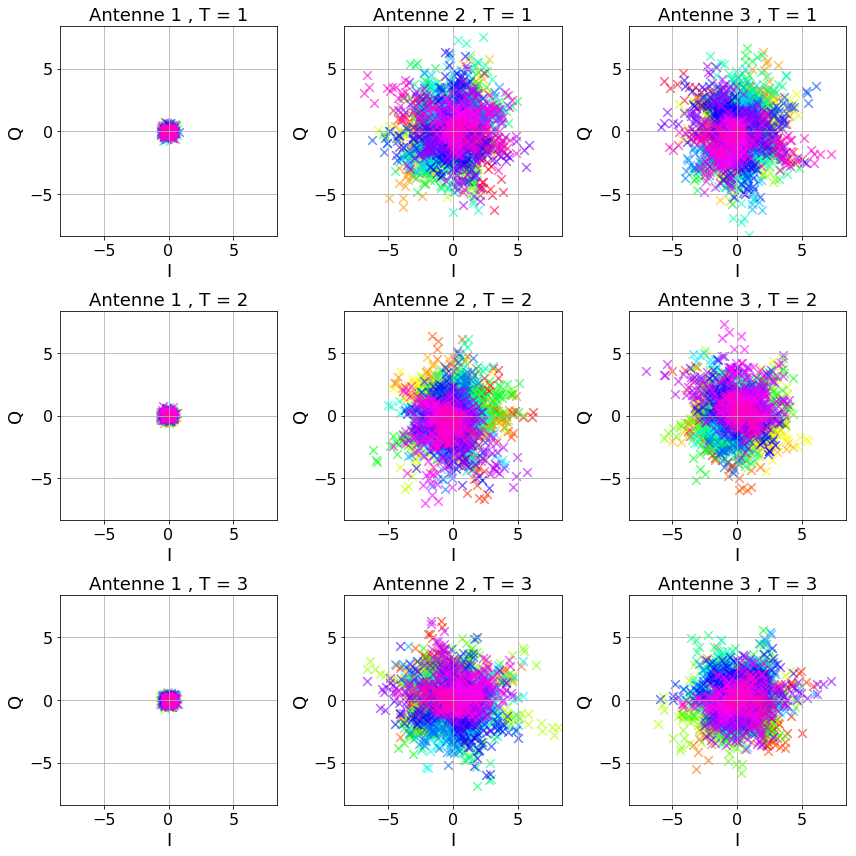

In [0]:
rtn = 1  # 0 for received symbols and 1 if after Predecoder-NN
ebno = 20
numofmsgrepeats= 50
y = ae.plot_receive(ebno, numofmsgrepeats, rtn)
plotfile = model_file_1 + 'Pics/receive_AE_' + model_file_2 + '_rtn_{}.pdf'.format(rtn)
plt.savefig(plotfile, bbox_inches='tight')

## BLER Simulations


Done. Simulation time: 51.98 sec bzw. 0.87 min


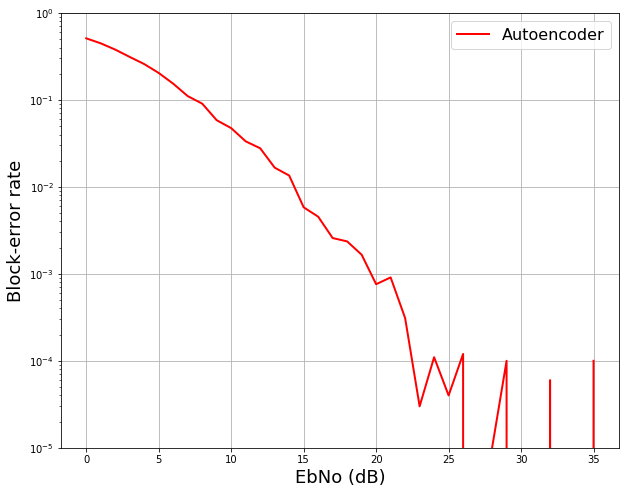

In [0]:
batch = 100
channel_realizations = 10000
ti = time.time()

# EbN0 Vector
ebnodbs = np.linspace(0, 35, 36)

# Simulation
print('Starting Simulation... \n')
blers = ae.bler_sim(ebnodbs, batch, channel_realizations)
ae.plot_bler(ebnodbs, blers)
elapsed_1 = time.time() - ti
print('\n Done. Simulation time: ' + str(round(elapsed_1, 2)) + ' sec bzw. ' + str(round(elapsed_1/60, 2)) + ' min')

# Save Fig
plotfile = model_file_1 + 'Pics/bler_ae' + model_file_2 + '.pdf'
plt.savefig(plotfile)


## BER Simulations

Starting Simulation... 

EbN0: 0.0 , Zeit: 0.78min , Averaged over: 1, Absolute Blockerrors: 4993, BER: 0.19793

EbN0: 1.0 , Zeit: 0.78min , Averaged over: 1, Absolute Blockerrors: 4530, BER: 0.18136

EbN0: 2.0 , Zeit: 0.78min , Averaged over: 1, Absolute Blockerrors: 4000, BER: 0.15759

EbN0: 3.0 , Zeit: 0.79min , Averaged over: 1, Absolute Blockerrors: 3261, BER: 0.13098

EbN0: 4.0 , Zeit: 0.79min , Averaged over: 1, Absolute Blockerrors: 2647, BER: 0.10372

EbN0: 5.0 , Zeit: 0.79min , Averaged over: 1, Absolute Blockerrors: 2040, BER: 0.07999

EbN0: 6.0 , Zeit: 0.8min , Averaged over: 1, Absolute Blockerrors: 1275, BER: 0.05243

EbN0: 7.0 , Zeit: 0.8min , Averaged over: 1, Absolute Blockerrors: 1349, BER: 0.05396

EbN0: 8.0 , Zeit: 0.8min , Averaged over: 1, Absolute Blockerrors: 1050, BER: 0.041

EbN0: 9.0 , Zeit: 0.81min , Averaged over: 1, Absolute Blockerrors: 756, BER: 0.03065

EbN0: 10.0 , Zeit: 0.81min , Averaged over: 1, Absolute Blockerrors: 425, BER: 0.0182

EbN0: 11.0 , Z

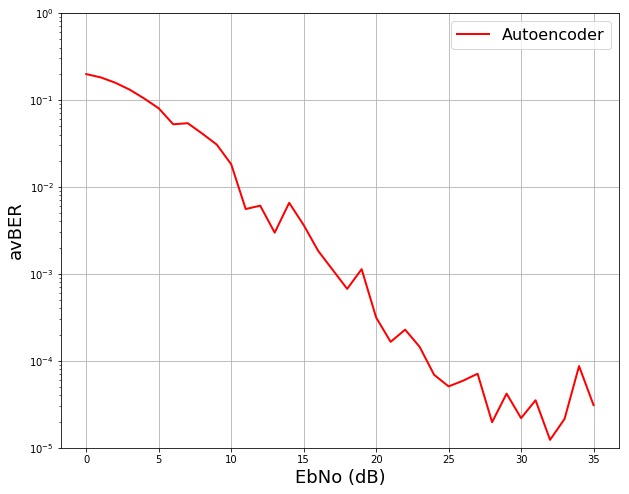

In [0]:
batch = 1000
channel_realizations = 10000
logfile = model_file_1 + 'Pickle/LOGDATA_BER_ae' + model_file_2 + '.txt'
ti = time.time()

# EbN0 Vector
ebnodbs = np.linspace(0, 35, 36)

# Simulation
print('Starting Simulation... \n')
_, ber = ae.plot_BER(batch, ebnodbs, channel_realizations, logfile)
elapsed_1 = time.time() - ti
print('\n Done. Simulation time: ' + str(round(elapsed_1, 2)) + ' sec bzw. ' + str(round(elapsed_1/60, 2)) + ' min')

# Save Fig and BER-Vector in Files
plotfile = model_file_1 + 'Pics/BER_ae' + model_file_2 + '.png'
plt.savefig(plotfile)

pick_file = model_file_1 + 'Pickle/BER_ae' + model_file_2 + '.pckl'
f = open(pick_file, 'wb')
pickle.dump(ber, f)
f.close()
